In [221]:
import pandas
import numpy as np

from clean import *

df_players_teams = pandas.read_csv("dataset/players_teams.csv")

df_players_teams = clean_teams_players(df_players_teams)

df_players_teams.head()

df_players= pandas.read_csv("dataset/players.csv")

df_players = clean_players(df_players)

df_merged = merge_player_info(df_players, df_players_teams) 

df_merged.head()



,playerID,year,stint,tmID,TotalGP,Points,TotalMinutes,TotaloRebounds,TotaldRebounds,TotalRebounds,...,TotalfgMade,TotalftAttempted,TotalftMade,TotalthreeAttempted,TotalthreeMade,TotalGS,TotalDQ,pos,height,weight
0,abrossv01w,2,0,MIN,26,343,846,43,131,174,...,114,132,96,76,19,23,2,F,74.0,169
1,abrossv01w,3,0,MIN,27,314,805,45,101,146,...,119,116,56,60,20,27,0,F,74.0,169
2,abrossv01w,4,0,MIN,33,341,861,45,101,146,...,118,106,77,89,28,28,0,F,74.0,169
3,abrossv01w,5,0,MIN,24,166,529,20,63,83,...,57,50,30,61,22,13,0,F,74.0,169
4,abrossv01w,6,0,MIN,31,304,777,29,78,107,...,109,73,53,82,33,31,0,F,74.0,169


c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


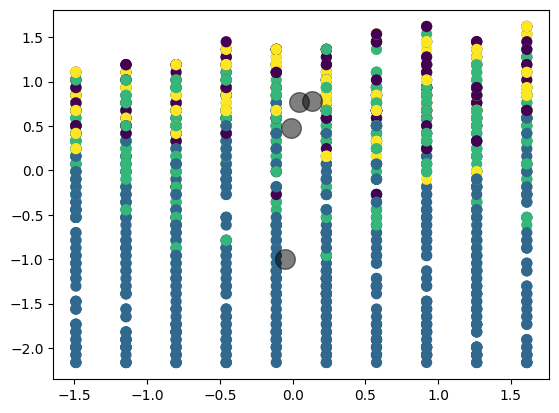

In [222]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# collumn tmID and stint should be dropped
df_players_teams = df_players_teams.drop(['tmID', 'stint'], axis=1)


X, Y = df_players_teams.iloc[:, 1:].values, df_players_teams.iloc[:, 0].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 4  # Number of clusters to create
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# graphic that shows the clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()


In [223]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline

def outliers_pipeline(X_):

    steps = [('scale', StandardScaler()),
             ('LOF', LocalOutlierFactor())
             ]
    outliers = Pipeline(steps).fit_predict(X_)

    return outliers

outliers = outliers_pipeline(X)

df_merged['outliers'] = outliers


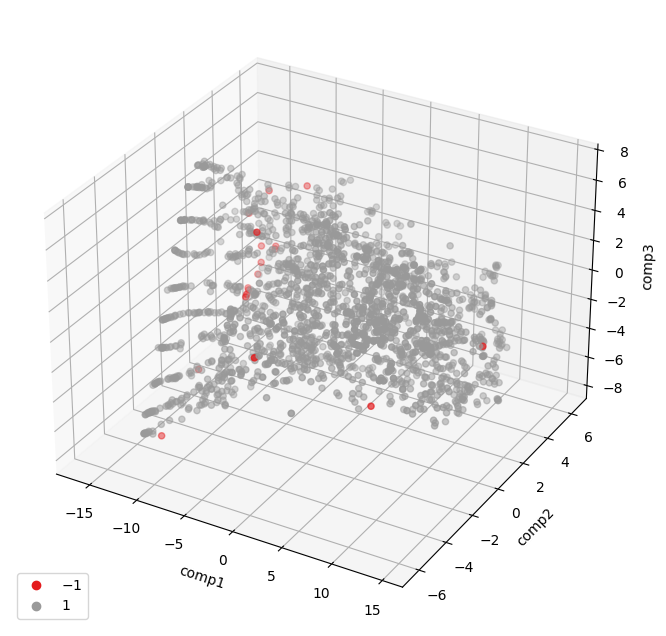

In [224]:
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

def print_outliers_plot(X_scaled, outliers, perp=50):

    tsne = TSNE(perplexity=perp, n_components=3).fit_transform(X_scaled) # we need a good perplexity value to separate the groups
    tsne = pandas.DataFrame(tsne, columns=['comp1', 'comp2', 'comp3'])
    tsne['outliers'] = outliers

    fig = plt.figure(figsize=(8, 8))  # create a new figure
    ax = fig.add_subplot(111, projection='3d')  # create a 3D subplot
    scatter = ax.scatter(tsne['comp1'], tsne['comp2'], tsne['comp3'],
                         c=tsne['outliers'], cmap='Set1')  # create 3D scatter plot
    #
    # add labels and legend
    ax.set_xlabel('comp1')
    ax.set_ylabel('comp2')
    ax.set_zlabel('comp3')
    plt.legend(*scatter.legend_elements(), loc='lower left')

    plt.show()  # display the plot

    return

print_outliers_plot(X_scaled, outliers)


In [225]:

df_best_and_worst = df_merged[df_merged['outliers'] == -1]
df_best_and_worst = df_best_and_worst.drop(['outliers'], axis=1)

# drop where stint != 0 ... as it skews the data
df_best_and_worst = df_best_and_worst[df_best_and_worst['stint'] == 0]

# show all uniques names
b_w_players = df_best_and_worst['playerID'].unique()

print(b_w_players)

['atkinla01w' 'catchta01w' 'chriska01w' 'clinest01w' 'coopecy01w'
 'crockwi01w' 'hornbal01w' 'payeka01w' 'scottol01w' 'stepama01w'
 'terryka01w' 'timmsmi01w' 'walkeay01w']


# TODO ... make this for every type of position / taking in case the defensive and ofensive statistics



0        F
8        C
9        G
14     F-G
46     G-F
98     F-C
455    C-F
Name: pos, dtype: object
position: F


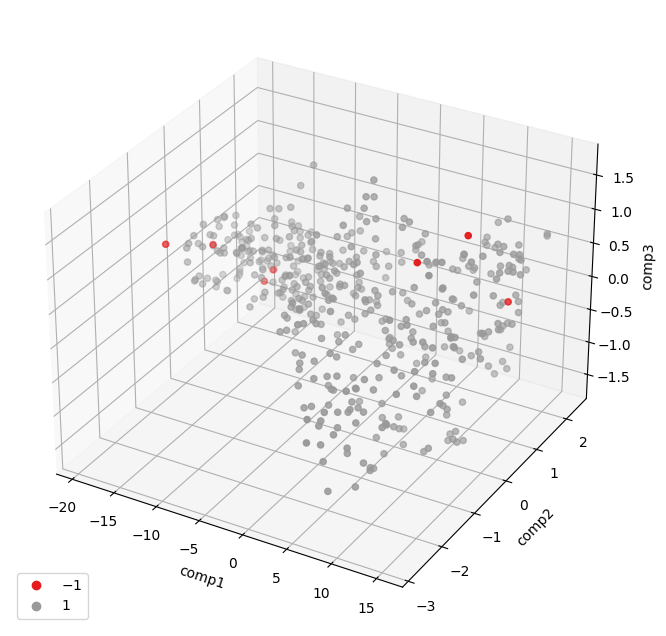

['catchta01w' 'chriska01w' 'crockwi01w' 'fordch01w' 'owenhe01w'
 'smithty01w' 'walkeay01w']
position: C


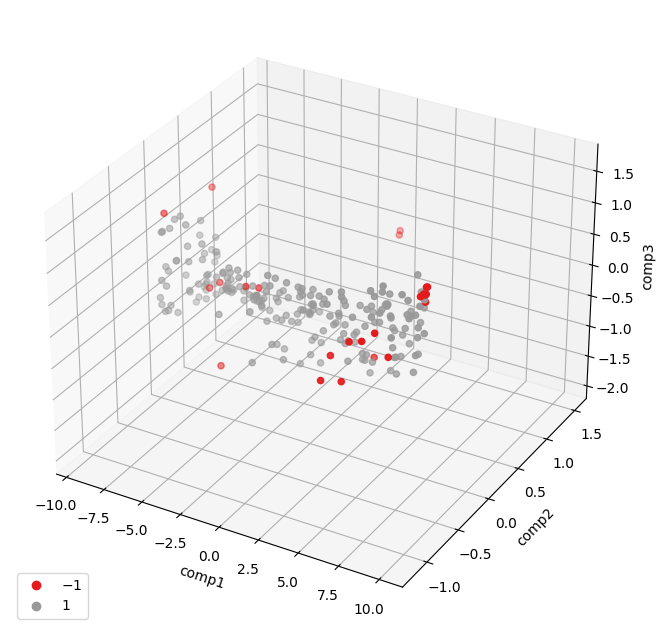

['adamsjo01w' 'batkosu01w' 'berezva01w' 'dydekma01w' 'leslili01w'
 'millebr01w' 'rileyru01w' 'sanniol01w' 'scottol01w' 'stepama01w'
 'walkema01w' 'wautean01w']
position: G


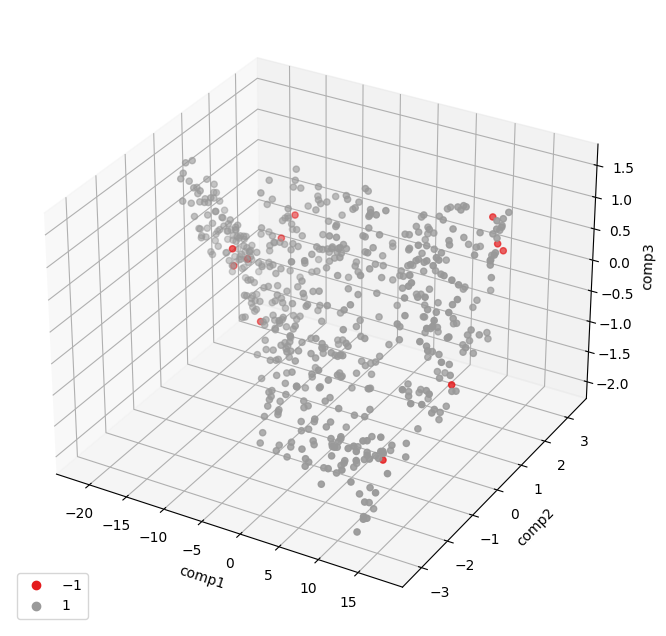

['bonnede01w' 'clinest01w' 'coopecy01w' 'davista02w' 'givench01w'
 'hornbal01w' 'payeka01w' 'timmsmi01w' 'wiggica01w' 'wrighta01w'
 'yamasli01w' 'zellosh01w']
position: F-G


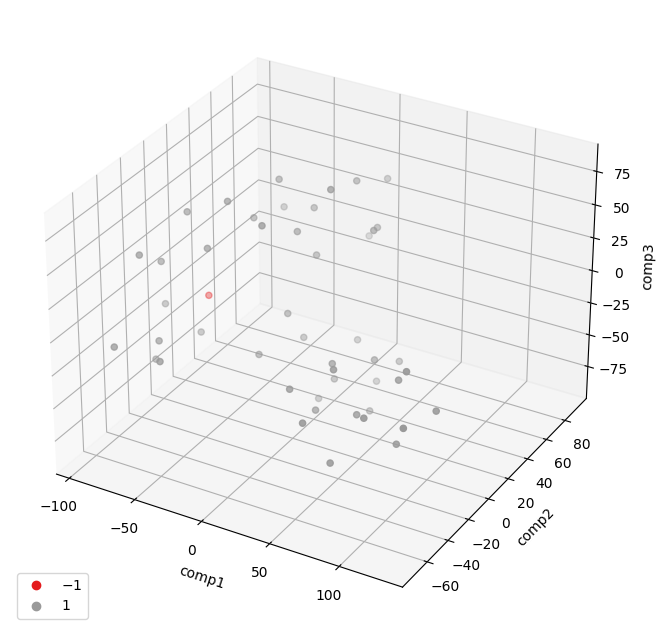

['tauradi01w']
position: G-F


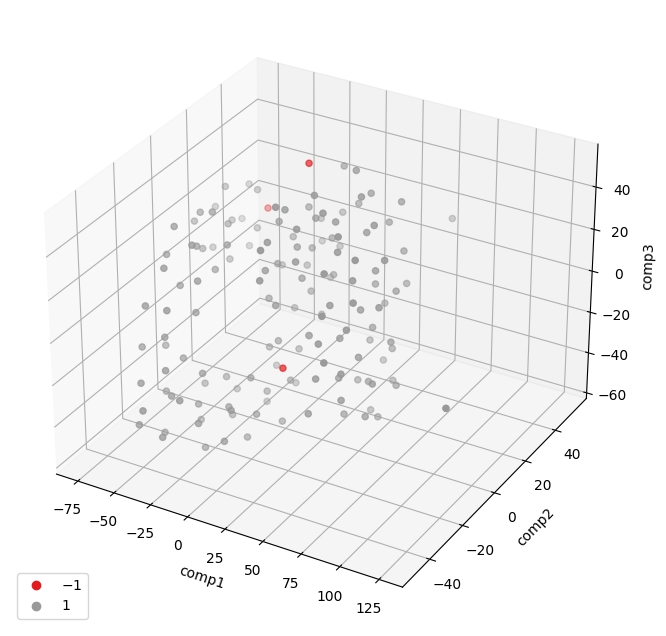

['atkinla01w' 'byearla01w']
position: F-C


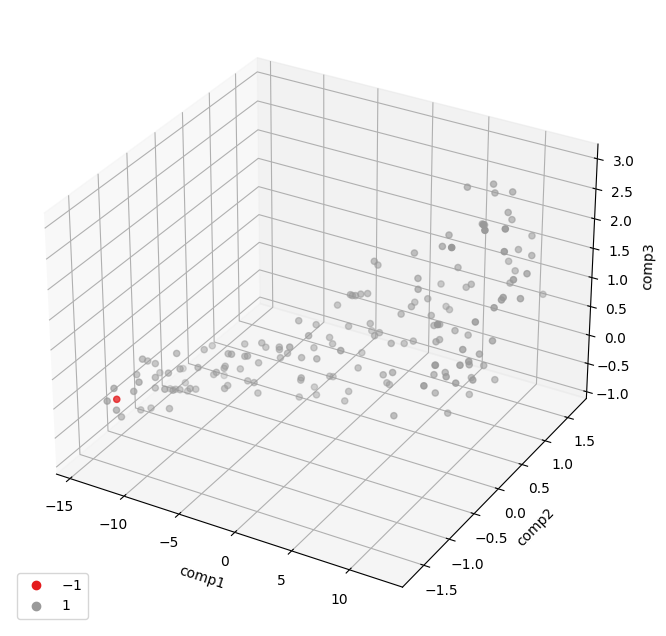

['lazicka01w']
position: C-F


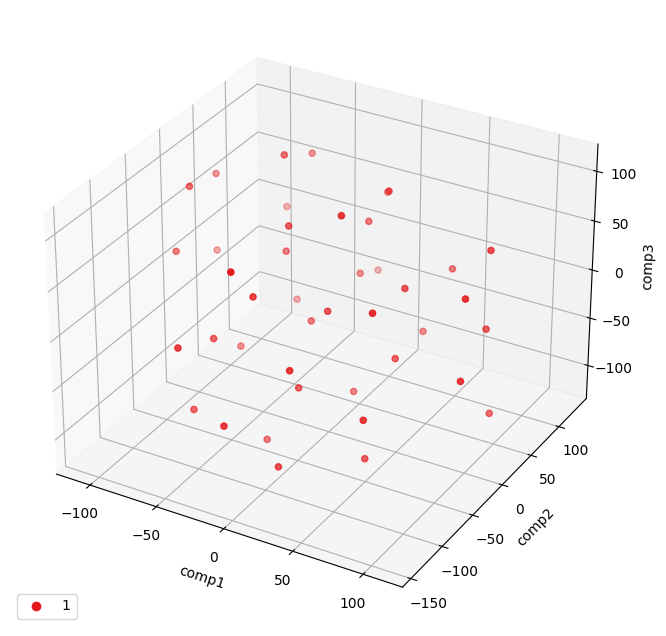

[]


In [226]:
unique_position = df_merged['pos'] 
unique_position = unique_position.drop_duplicates()

print(unique_position)

perp = [50,50,50,10,25,25,25]

perp_index = 0
for i in unique_position:
    df_i = df_merged[df_merged['pos'] == i]

    df_i = df_i.drop(['tmID', 'pos'], axis=1)

    df_i = df_i[df_i['stint'] == 0]


    x = df_i.iloc[:, 1:].values

    print(f"position: {i}")
    outliers = outliers_pipeline(x)
    df_i['outliers'] = outliers

    print_outliers_plot(x, outliers, perp=perp[perp_index])

    # print the outliers
    df_i = df_i[df_i['outliers'] == -1]
    df_i = df_i.drop(['outliers'], axis=1)
    print(df_i['playerID'].unique())

    perp_index += 1





In [227]:
# df_merged['PointsPerMin'] = df_merged['Points'].div(df_merged['TotalMinutes'])
# df_merged['oReboundsPerMin'] = df_merged['TotaloRebounds'].div(df_merged['TotalMinutes'])
# df_merged['dReboundsPerMin'] = df_merged['TotaldRebounds'].div(df_merged['TotalMinutes'])
# df_merged['ReboundsPerMin'] = df_merged['TotalRebounds'].div(df_merged['TotalMinutes'])
# df_merged['AssistsPerMin'] = df_merged['TotalAssists'].div(df_merged['TotalMinutes'])
# df_merged['StealsPerMin'] = df_merged['TotalSteals'].div(df_merged['TotalMinutes'])
# df_merged['BlocksPerMin'] = df_merged['TotalBlocks'].div(df_merged['TotalMinutes'])
# df_merged['TurnoversPerMin'] = df_merged['TotalTurnovers'].div(df_merged['TotalMinutes'])
# df_merged['PFPerMin'] = df_merged['TotalPF'].div(df_merged['TotalMinutes'])
# df_merged['fgAttemptedPerMin'] = df_merged['TotalfgAttempted'].div(df_merged['TotalMinutes'])
# df_merged['fgMadePerMin'] = df_merged['TotalfgMade'].div(df_merged['TotalMinutes'])
# df_merged['ftAttemptedPerMin'] = df_merged['TotalftAttempted'].div(df_merged['TotalMinutes'])
# df_merged['ftMadePerMin'] = df_merged['TotalftMade'].div(df_merged['TotalMinutes'])
# df_merged['threeAttemptedPerMin'] = df_merged['TotalthreeAttempted'].div(df_merged['TotalMinutes'])
# df_merged['threeMadePerMin'] = df_merged['TotalthreeMade'].div(df_merged['TotalMinutes'])
# 
# df_merged.fillna(0, inplace=True)
## Existe um problema com esta abordagem, jogadores que jogaram pouco mas bem podem ter uma vantagem

df_merged = df_merged.drop(['year','TotalMinutes','TotalGP'], axis=1)

df_merged.head()

,playerID,stint,tmID,Points,TotaloRebounds,TotaldRebounds,TotalRebounds,TotalAssists,TotalSteals,TotalBlocks,...,TotalftAttempted,TotalftMade,TotalthreeAttempted,TotalthreeMade,TotalGS,TotalDQ,pos,height,weight,outliers
0,abrossv01w,0,MIN,343,43,131,174,53,42,9,...,132,96,76,19,23,2,F,74.0,169,1
1,abrossv01w,0,MIN,314,45,101,146,60,42,10,...,116,56,60,20,27,0,F,74.0,169,1
2,abrossv01w,0,MIN,341,45,101,146,86,48,12,...,106,77,89,28,28,0,F,74.0,169,1
3,abrossv01w,0,MIN,166,20,63,83,48,31,4,...,50,30,61,22,13,0,F,74.0,169,1
4,abrossv01w,0,MIN,304,29,78,107,60,48,6,...,73,53,82,33,31,0,F,74.0,169,1


In [229]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# drop all non numerical atributes
df_merged = df_merged.select_dtypes(include=['float64', 'int64'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged)

df_merged = pandas.DataFrame(X_scaled, columns=df_merged.columns)


df_merged['medium'] = df_merged.mean(axis=1) # TODO: make this not by year but by player years performance


Y_ = df_merged['medium'] 

gb_model.fit(X_scaled, Y_)

y_pred = gb_model.predict(X_scaled)

mse = mean_squared_error(Y_, y_pred)

# add player Id back and print the predictions for each row
df_merged['playerID'] = df_players_teams['playerID']
df_merged['predictions'] = y_pred
df_merged['medium'] = Y_

# drop all atributes exept playerID, medium and predictions
df_pred = df_merged

# print the 5 most rated players
df_pred = df_pred.sort_values(by=['medium'], ascending=False)
df_pred.head(10)



,stint,Points,TotaloRebounds,TotaldRebounds,TotalRebounds,TotalAssists,TotalSteals,TotalBlocks,TotalTurnovers,TotalPF,...,TotalftMade,TotalthreeAttempted,TotalthreeMade,TotalGS,TotalDQ,height,weight,medium,predictions,playerID
904,-0.268757,3.192815,3.507735,3.893485,3.894483,1.167168,1.304014,6.193749,2.769794,2.703546,...,3.359951,0.578612,0.651493,1.643690,2.749880,0.953265,0.121950,2.502551,2.496131,leslili01w
905,-0.268757,2.505765,2.412931,4.135372,3.699084,1.167168,1.878258,6.529723,2.508790,2.464220,...,2.711120,0.145877,0.225026,1.576796,7.050650,0.953265,0.121950,2.470118,2.466309,leslili01w
1590,-0.268757,3.829593,0.027824,2.925936,2.057728,2.450471,1.199606,3.169979,2.476165,2.224894,...,3.912658,4.748601,5.182704,1.911267,1.674687,0.047784,0.203193,2.468684,2.466598,tauradi01w
285,-0.268757,2.757125,3.273134,3.353890,3.438551,2.675612,5.793555,1.490107,2.704543,1.958976,...,4.080874,2.368560,1.930894,2.045056,0.599494,0.228880,0.000087,2.429287,2.429184,catchta01w
909,-0.268757,3.086685,2.686632,3.819058,3.568817,1.684992,1.773850,3.707538,3.389679,2.198302,...,3.383982,-0.286858,-0.201441,1.710584,3.825072,0.953265,0.121950,2.355821,2.357901,leslili01w
903,-0.268757,2.539279,2.295631,3.781844,3.412498,0.581802,0.573158,4.648266,2.508790,2.543996,...,3.576228,-0.050821,-0.308058,1.509901,7.050650,0.953265,0.121950,2.260712,2.259461,leslili01w
907,-0.268757,2.466664,1.474529,4.451686,3.607897,1.077112,1.565034,6.462528,2.574041,2.331261,...,2.711120,-0.306527,-0.361366,1.576796,4.900265,0.953265,0.121950,2.247920,2.247819,leslili01w
278,-0.268757,2.595137,3.038533,2.702655,2.904459,1.865105,4.018620,2.296446,1.758404,1.586691,...,2.879336,3.470067,3.796687,1.443007,1.674687,0.228880,0.000087,2.235218,2.230362,catchta01w
910,-0.268757,2.176204,2.725732,3.558564,3.399471,1.144654,1.826054,7.000087,3.454930,2.490812,...,2.230505,-0.326197,-0.361366,1.710584,3.825072,0.953265,0.121950,2.226569,2.225692,leslili01w
1588,-0.268757,3.360388,-0.089476,1.697892,1.158891,2.743154,1.930461,2.094861,2.052033,2.251486,...,2.062290,5.968127,6.088946,1.844373,1.674687,0.047784,0.203193,2.222157,2.224274,tauradi01w
